# Test for bike trafic model

In [4]:
import sys
from pathlib import Path

# Trouve le dossier racine du projet (celui qui contient 'src')
project_root = Path().resolve().parents[0]  # si ton notebook est dans 'notebook/'
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from bike import indicators as ind
from bike import utils as ut
import matplotlib.cm as cm
from matplotlib.lines import Line2D

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix

from utils_traffic import *

from pypalettes import load_palette


## Fonction definition

In [219]:
###### preprocessing functions
def set_capacity_cars(edges_df, capacity_per_lane=100, lanes_col='lanes'):
    edges_df['capacity_cars'] = edges_df[lanes_col]*capacity_per_lane
    return edges_df

def set_capacity_bikes(edges_df, capacity_per_lane=200, lanes_col='lanes'):
    edges_df['capacity_bikes'] = edges_df[lanes_col]*capacity_per_lane
    return edges_df

def time_estimation_cars(edges_df):
    travel_time = []
    for _, edge in edges_df.iterrows():
        travel_time.append((edge['length']/1000)/(edge['speed']*0.5))
    edges_df['travel_time_cars'] = travel_time
    return edges_df

def simple_bi(edges_df, coef = 1):
    length_bi = []
    for _, edge in edges_df.iterrows():
        if edge['type_bike'] == 'bike_lane':
            length_bi.append(edge['length']*0.9*coef)
        elif edge['type_bike'] == 'bike_path':
            length_bi.append(edge['length']*0.5*coef)
        else:
            length_bi.append(edge['length']*2*coef)
    edges_df['length_bi'] = length_bi
    return edges_df

def estimate_traffic (edges_df):
    traffic = []
    for _, edge in edges_df.iterrows():
        if edge['type_car']=='primary':
            traffic.append(500)
        elif edge['type_car']=='secondary':
            traffic.append(250)
        else :
            traffic.append(100)
    edges_df['traffic'] = traffic
    return edges_df

def pl_type_bike(type):
    if type == 'bike_lane' :
        return 0.9
    elif type == 'bike_path':
        return 0.7
    else :
        return 1.2

def pl_slope(slope):
    if abs(slope) > 0.6:
        return 1.1
    else:
        return 1
    
def pl_green(gb_coverage):
    if gb_coverage > 0.5:
        return 0.9
    else :
        return 1
    
def pl_traffic(traffic):
    if traffic > 100:
        return 1.3
    elif traffic < 25:
        return 1
    else :
        return 1.1
    

def simple_bi_2(edges_df):
    length_bi = []
    for _, edge in edges_df.iterrows():
        perceived_l = 0
        perceived_l += pl_type_bike(edge['type_bike'])
        perceived_l += pl_slope(edge['slope'])
        perceived_l += pl_green(edge['green_blue_coverage'])
        perceived_l += pl_traffic(edge['traffic'])
        length_bi.append(perceived_l/4)
    edges_df['length_bi'] = length_bi
    return edges_df

    
def reset_flows(edges_df, flow_key='flow'):
    edges_df[flow_key] = 0
    return edges_df


#### plotting functions
def _create_offset_polygon(coords, width):
    """Create polygon offset to right of line."""
    if len(coords) < 2:
        return None

    right_pts, left_pts = [], []
    for i, (cx, cy) in enumerate(coords):
        if i == 0:
            dx, dy = coords[1][0] - coords[0][0], coords[1][1] - coords[0][1]
        elif i == len(coords) - 1:
            dx, dy = coords[-1][0] - coords[-2][0], coords[-1][1] - coords[-2][1]
        else:
            dx = (coords[i + 1][0] - coords[i - 1][0]) / 2
            dy = (coords[i + 1][1] - coords[i - 1][1]) / 2

        length = np.sqrt(dx ** 2 + dy ** 2)
        if length > 0:
            dx, dy = dx / length, dy / length

        perp_x, perp_y = dy, -dx
        right_pts.append((cx + perp_x * width, cy + perp_y * width))
        left_pts.append((cx, cy))

    try:
        polygon = Polygon(right_pts + left_pts[::-1])
        return polygon if polygon.is_valid else polygon.buffer(0)
    except:
        return None

def plot_network(edges_df, nodes_df, ax=None, figsize=(10,10), node_x_col='x', node_y_col='y', 
                 width_col=None, base_width=0.1, width_scale=2.1, node_id_col='node', color_col_num=None, color_col_str=None, dict_colors_str=None,
                 vmin=None, vmax=None, a_node_col='a_node', b_node_col='b_node', show_nodes=True,
                 node_size=100, cmap='viridis', colorbar_label=None, title=None, node_label=False, legend=False, edges_label_col=None):
    
    edges_df = edges_df.reset_index(drop=True)

    if dict_colors_str is not None:
        dict_colors = dict_colors_str
    else:
        dict_colors = {'bike_path': '#4E9F50FF', 'bike_lane': '#EF8A0CFF', 'none':'black'}
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x_range = nodes_df[node_x_col].max() - nodes_df[node_x_col].min()
    y_range = nodes_df[node_y_col].max() - nodes_df[node_y_col].min()
    scale = min(x_range, y_range) / 100

    scaled_base = scale * base_width
    scaled_scale = scale * width_scale * 0.0001

    node_coords = {r[node_id_col]: (r[node_x_col], r[node_y_col])
                   for _, r in nodes_df.iterrows()}
    
    if width_col is not None:
        width_vals = edges_df[width_col].fillna(0).values if width_col in edges_df.columns else np.ones(len(edges_df))
        if color_col_num is None:
            color_col_num = width_col
    
    if color_col_num in edges_df.columns:
        color_vals = edges_df[color_col_num].fillna(0).values

        # Use provided vmin/vmax or compute from data
        if vmin is None:
            vmin = np.nanmin(color_vals)
        if vmax is None:
            vmax = np.nanmax(color_vals)
        if vmin == vmax:
            vmax = vmin + 1

        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        use_cmap = True
    else:
        use_cmap = False
    
    if color_col_str in edges_df.columns:
        color_vals = []
        for edge in edges_df.itertuples():
            color_vals.append(dict_colors.get(getattr(edge, color_col_str), 'black'))
        use_cmap = False
    
    # Use enumerate to get integer index for numpy array access
    for idx, edge in edges_df.iterrows():
        a_coords = node_coords.get(edge[a_node_col])
        b_coords = node_coords.get(edge[b_node_col])
        if a_coords is None or b_coords is None:
            continue

        # Use idx (which is now 0..N-1 due to reset_index) to access arrays
        if width_col is not None:
            width = scaled_base + width_vals[idx] * scaled_scale
        else:
            width = scaled_base
        polygon = _create_offset_polygon([a_coords, b_coords], width)

        if polygon:
            color = sm.to_rgba(color_vals[idx]) if use_cmap else color_vals[idx]
            x, y = polygon.exterior.xy
            ax.fill(x, y, color=color, alpha=1, edgecolor='black', linewidth=0.1)

    if show_nodes:
        ax.scatter(nodes_df[node_x_col], nodes_df[node_y_col], s=node_size, c='white', zorder=5, edgecolors='black')
        if node_label :
            for _, row in nodes_df.iterrows():
                ax.text(row[node_x_col], row[node_y_col], str(int(row[node_id_col])), fontsize=8,
                        ha='center', va='center', zorder=6)

    if legend and color_col_str is not None:
        legend_elements = []
        for key, color in dict_colors.items():
            legend_elements.append(Line2D([0], [0], color=color, lw=4, label=key))
        ax.legend(handles=legend_elements, loc='lower right')
        
    if use_cmap:
        # Determine colorbar label
        if colorbar_label is None:
            colorbar_label = color_col_num.replace('_', ' ').title()
        cbar = plt.colorbar(sm, ax=ax, label=colorbar_label, shrink=0.8)

    if edges_label_col is not None and edges_label_col in edges_df.columns:
        for _, edge in edges_df.iterrows():
            a_coords = node_coords.get(edge[a_node_col])
            b_coords = node_coords.get(edge[b_node_col])
            if a_coords is None or b_coords is None:
                continue
            mid_x = (a_coords[0] + b_coords[0]) / 2
            mid_y = (a_coords[1] + b_coords[1]) / 2
            if a_coords[0] == b_coords[0]:  # horizontal line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white', rotation='vertical')
            else:  # vertical line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white')
            
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title(title or f'Network (width by {width_col})')
    plt.tight_layout()

    return fig, ax

##### eaquilibrae pre processing

def convert_to_eaquilibrae_df(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    return edges_df

def convert_to_eaquilibrae_df_v2(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    edges_df_2 = edges_df.copy()
    edges_df_2.rename(columns={'a_node': 'b_node', 'b_node': 'a_node'}, inplace=True)
    edges_df = pd.concat([edges_df, edges_df_2], ignore_index=True)
    return edges_df, len(edges_df_2)

def convert_to_eaquilibrae_od_matrix(od_matrix):
    od_long = od_matrix.stack().reset_index()
    od_long.columns = ["origin", "destination", "demand"]
    return od_long

def convert_from_eaquilibrae_df_to_graph(results_stochastic):
    network_with_flows = results_stochastic['network']
    G_2 = nx.from_pandas_edgelist(
    network_with_flows,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2

def convert_from_eaquilibrae_df_to_graph_v2(results_stochastic, len_df):
    network_with_flows = results_stochastic['network']
    print(network_with_flows)
    base_df = network_with_flows[:len_df].copy()
    print(base_df)
    reversed_df = network_with_flows[len_df:].copy()
    print(reversed_df)
    base_df['flow'] = base_df['flow'] + reversed_df['flow'].values
    G_2 = nx.from_pandas_edgelist(
    base_df,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2



#####models

def _build_demand_matrix(od_gdf, name='matrix'):
    """Convert OD GeoDataFrame to AequilibraeMatrix."""
    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    od_matrix = np.zeros((zones, zones))

    for _, row in od_gdf.iterrows():
        od_matrix[int(row['origin']) - 1, int(row['destination']) - 1] = row['demand']

    demand = AequilibraeMatrix()
    demand.create_empty(zones=zones, matrix_names=[name], memory_only=True)
    demand.matrix[name][:, :] = od_matrix
    demand.index[:] = np.arange(1, zones + 1).astype(int)
    demand.computational_view([name])

    return demand

def _build_graph_for_stochastic(network_df, zones, time_field, cost_field, capacity_field='capacity'):
    """Build graph for stochastic assignment."""
    network_df = network_df.copy()
    network_df['direction'] = 1
    network_df.index = list(range(len(network_df)))
    network_df["link_id"] = network_df.reset_index().index + 1
    network_df = network_df.astype({"a_node": "int64", "b_node": "int64", "direction": "int64", "link_id": "int64"})

    g = Graph()
    g.cost = network_df[cost_field].values
    g.capacity = network_df[capacity_field].values
    g.free_flow = network_df[time_field].values

    g.network = network_df
    g.network_ok = True
    g.status = 'OK'
    g.prepare_graph(np.arange(1, zones + 1).astype(int))
    g.set_graph(cost_field)
    g.cost = np.array(g.cost, copy=True)
    g.set_blocked_centroid_flows(False)
    g.network["id"] = g.network.link_id

    return g

def _empty_result(results_df, n):
    """Return empty result dict for failed assignments."""
    results_df['flow'] = np.zeros(n)
    results_df['time'] = np.zeros(n)
    return {
        'network': results_df,
        'total_travel_time': np.inf,
        'computation_time': 0,
        'rgap': np.inf,
        'flow': np.zeros(n),
        'time': np.zeros(n),
        'convergence': None
    }

def ta_stochastic(edges_gdf, od_gdf, mode='car',
                  time_field='free_flow_time', cost_field='free_flow_time', capacity_field='capacity',
                  algorithm='bfsle', max_routes=5, max_depth=100, max_misses=100,
                  beta=1.0, cutoff_prob=0.0, penalty=1.0, seed=0, cores=1):
    """
    Stochastic (uncongested) traffic assignment using Route Choice.
    """
    network_df = edges_gdf.copy()
    if 'geometry' in network_df.columns:
        network_df = pd.DataFrame(network_df.drop(columns=['geometry']))

    network_df[capacity_field] = network_df[capacity_field].fillna(99999)
    network_df[time_field] = network_df[time_field].fillna(100.01)
    if cost_field != time_field:
        network_df[cost_field] = network_df[cost_field].fillna(100.01)

    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    demand = _build_demand_matrix(od_gdf)

    network_df = network_df.sort_values(by=['a_node', 'b_node']).reset_index(drop=True)
    graph = _build_graph_for_stochastic(network_df, zones, time_field, cost_field, capacity_field=capacity_field)

    route_choice = RouteChoice(graph)
    route_choice.set_cores(cores)
    route_choice.set_choice_set_generation(
        algorithm=algorithm,
        max_routes=max_routes,
        max_depth=max_depth,
        max_misses=max_misses,
        beta=beta,
        cutoff_prob=cutoff_prob,
        penalty=penalty,
        seed=seed
    )
    route_choice.add_demand(demand)
    route_choice.prepare(nodes=None)

    results_df = network_df.copy()
    start_time = time.time()

    try:
        route_choice.execute(perform_assignment=True)
        computation_time = time.time() - start_time

        load_results = route_choice.get_load_results()
        flows = load_results['matrix_ab'].values
        times = results_df[time_field].values
        costs = results_df[cost_field].values

        total_travel_time = np.sum(flows * times)
        total_travel_cost = np.sum(flows * costs)

        results_df['flow'] = flows
        results_df['time'] = times
        results_df['cost'] = costs

        print(f"Stochastic ({mode}) completed in {computation_time:.2f}s | TTT: {total_travel_time:.0f}")

        return {
            'network': results_df,
            'total_travel_time': total_travel_time,
            'total_travel_cost': total_travel_cost,
            'computation_time': computation_time,
            'flow': flows,
            'time': times,
            'cost': costs
        }

    except Exception as e:
        print(f"Error in stochastic assignment: {e}")
        import traceback
        traceback.print_exc()
        return _empty_result(results_df, len(network_df))


def model_eaquilibrae_stochastic(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df = convert_to_eaquilibrae_df(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph(results_stochastic)
    return G_2

def model_eaquilibrae_stochastic_v2(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df, len_df = convert_to_eaquilibrae_df_v2(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph_v2(results_stochastic, len_df)
    return G_2



## Import and pre proccessing

In [220]:
edge_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_2.csv")
node_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_2.csv")

In [221]:
edge_df['slope']=1
edge_df['green_blue_coverage']=0.7

In [222]:
edge_df = simple_bi(edge_df)
edge_df = estimate_traffic(edge_df)
edge_df = set_capacity_bikes(edge_df, capacity_per_lane=200)
edge_df = set_capacity_cars(edge_df, capacity_per_lane=1000)
edge_df = time_estimation_cars(edge_df)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Network (width by None)'}>)

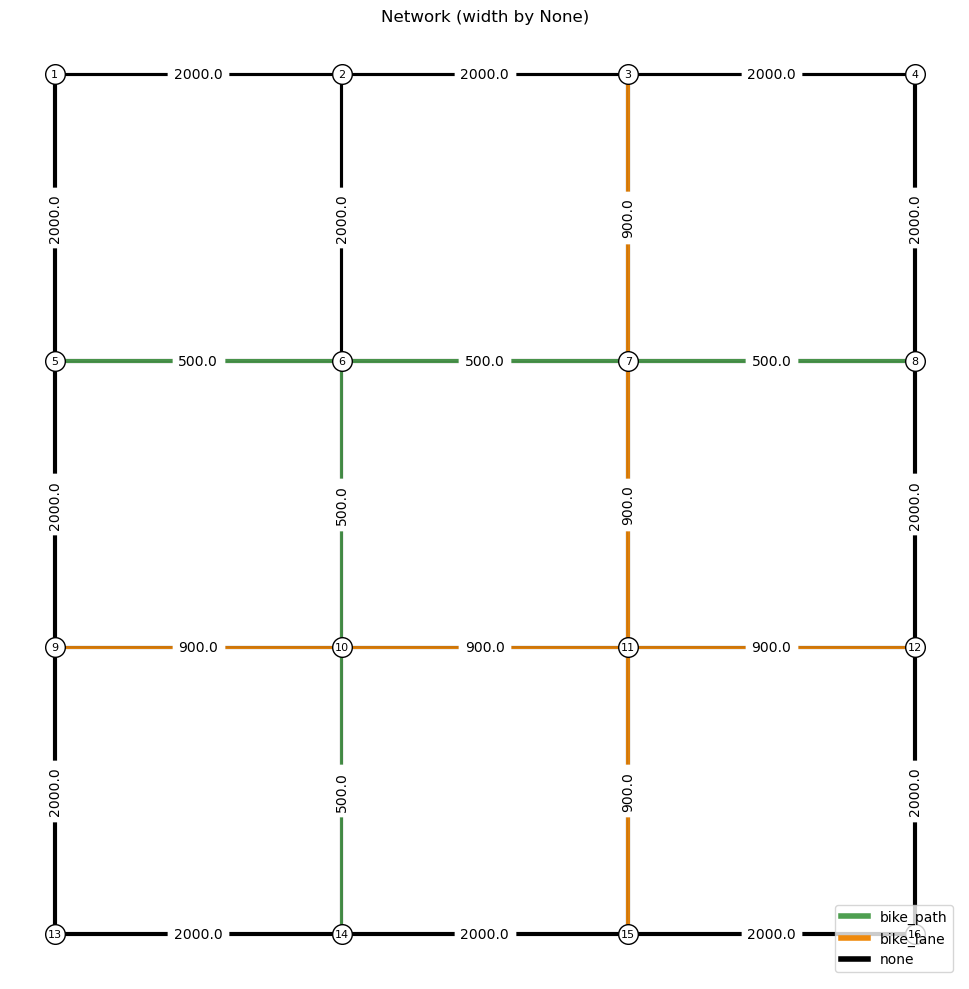

In [223]:
plot_network(edge_df, node_df, color_col_str='type_bike', base_width=0.2, width_scale=5, node_size=200, legend=True,  node_label=True, edges_label_col='length_bi')

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Network (width by traffic)'}>)

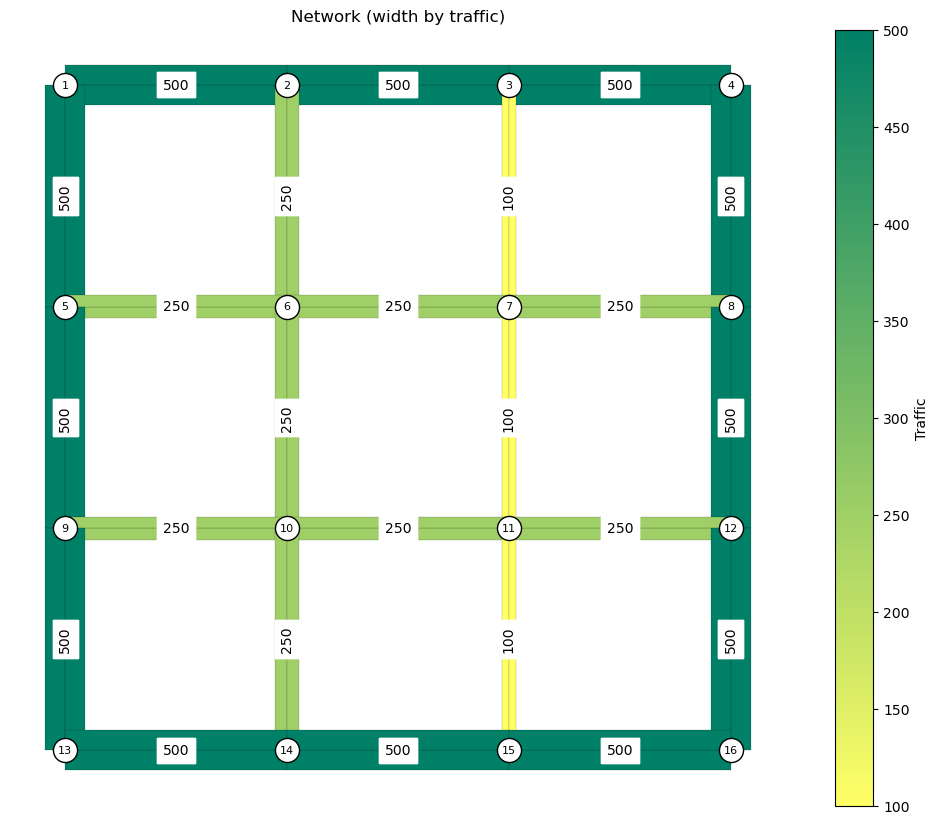

In [224]:
plot_network(edge_df, node_df, node_size=300, node_label=True, color_col_num='traffic', base_width=0.5, legend=True, width_col='traffic', width_scale=50, edges_label_col='traffic',cmap="summer_r")

In [225]:
modal_share = {'bike': 0.25, 'car': 0.75}
od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
od_matrix.loc[1,16] = 100
od_matrix.loc[2,14]=100
od_matrix.loc[13,4]=100
od_bike = od_matrix.copy()
od_bike = od_bike*modal_share['bike']
od_car = od_matrix.copy()
od_car = od_car*modal_share['car']
od_bike = convert_to_eaquilibrae_od_matrix(od_bike)
od_car = convert_to_eaquilibrae_od_matrix(od_car)

## Models

In [226]:
cars_results = ta_stochastic(edge_df, od_car, mode='cars',
                  time_field='travel_time_cars', cost_field='length',
                  algorithm='bfsle', max_routes=1, 
                  capacity_field='capacity_cars')

print(f"\n--- Car Results ---")
print(f"Total Travel Time: {cars_results['total_travel_time']:,.0f} min")
print(f"Computation Time:  {cars_results['computation_time']:.2f} s")
print(f"Links with flow:   {(cars_results['flow'] > 0).sum()} out of {len(cars_results['flow'])}")
print(f"Max link flow:     {cars_results['flow'].max():,.0f}")

Stochastic (cars) completed in 0.00s | TTT: 44

--- Car Results ---
Total Travel Time: 44 min
Computation Time:  0.00 s
Links with flow:   13 out of 48
Max link flow:     150


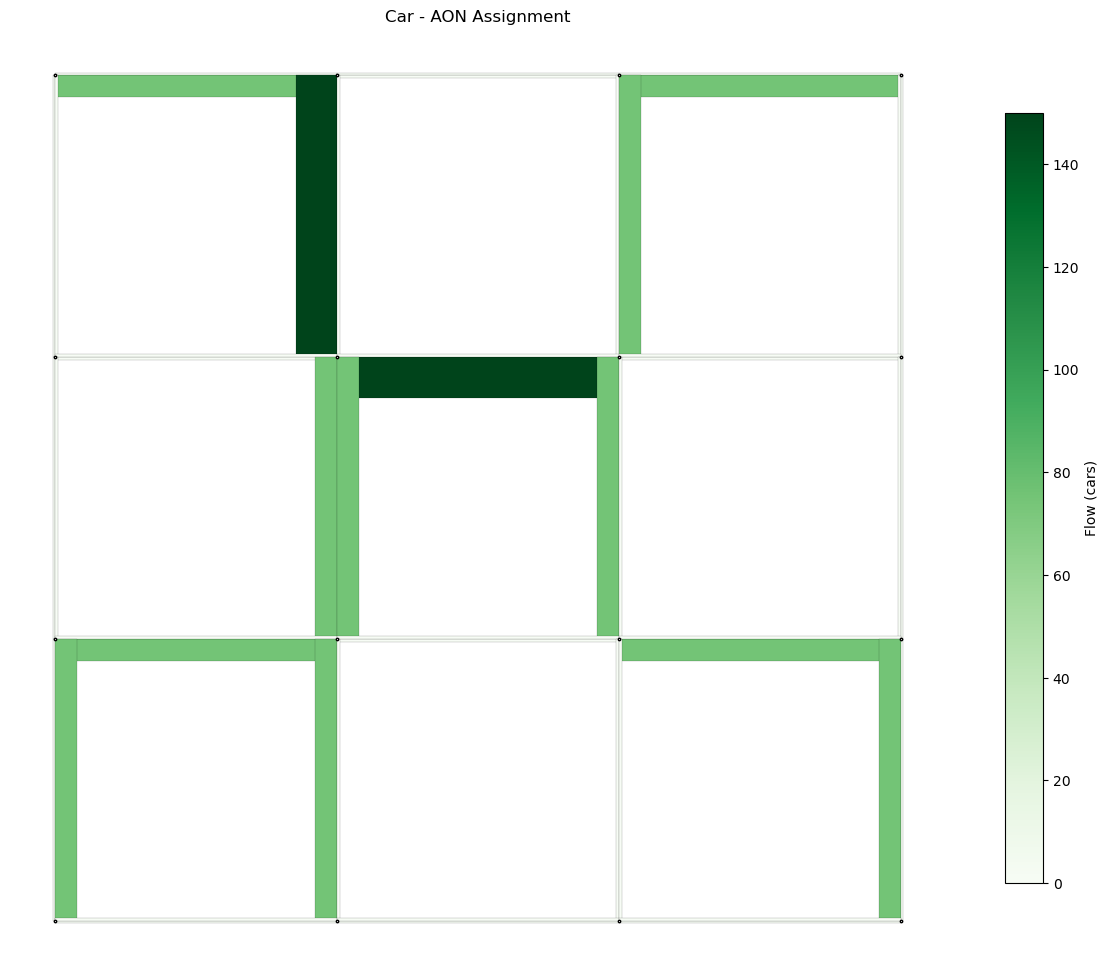

In [227]:
fig, ax = plot_network(
    cars_results['network'], node_df,
    width_col='flow',
    color_col_num='flow',
    cmap='Greens',
    title='Car - AON Assignment',
    figsize=(12, 10),
    node_size=3,
    colorbar_label='Flow (cars)',
    base_width=0.3,
    width_scale=300
)
edge_df["traffic"] = cars_results['network']['flow']

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Network (width by None)'}>)

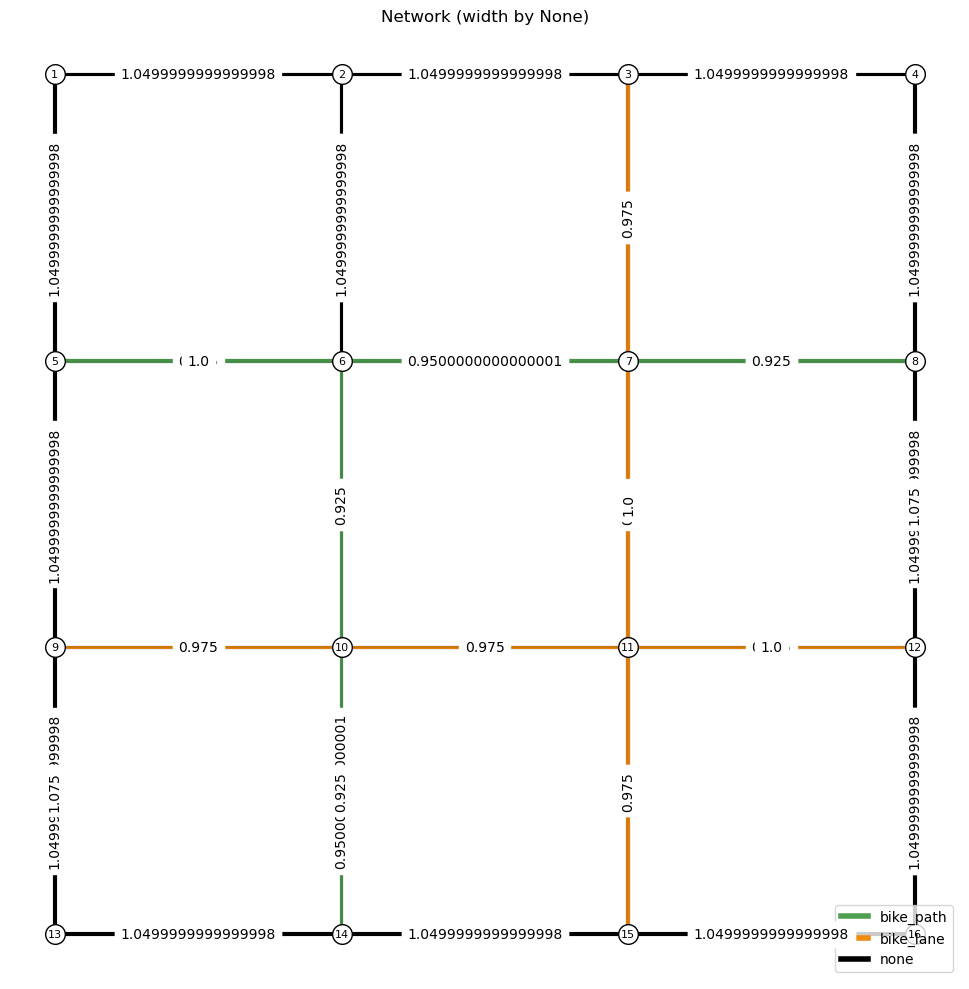

In [229]:
edge_df = simple_bi_2(edge_df)
plot_network(edge_df, node_df, color_col_str='type_bike', base_width=0.2, width_scale=5, node_size=200, legend=True,  node_label=True, edges_label_col='length_bi')

Stochastic (bikes) completed in 0.00s | TTT: 386


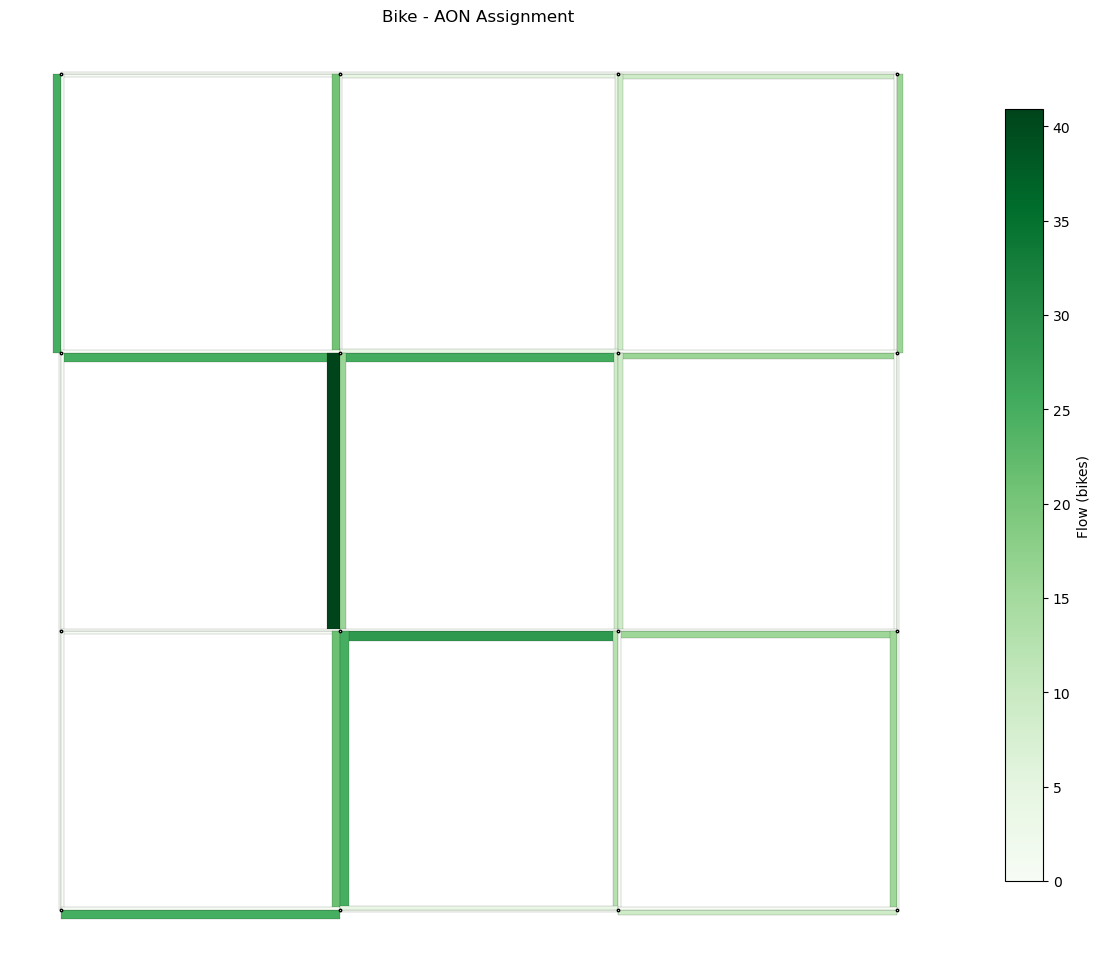

In [230]:
bike_results = ta_stochastic(edge_df, od_bike, mode='bikes',
                  time_field='length_bi', cost_field='length_bi',
                  algorithm='bfsle', max_routes=3, 
                  capacity_field='capacity_bikes')

fig, ax = plot_network(
    bike_results['network'], node_df,
    width_col='flow',
    color_col_num='flow',
    cmap='Greens',
    title='Bike - AON Assignment',
    figsize=(12, 10),
    node_size=3,
    colorbar_label='Flow (bikes)',
    base_width=0.3,
    width_scale=300
)

Text(0.5, 1.0, 'Bike infrastructure - with adjustment to cars traffic')

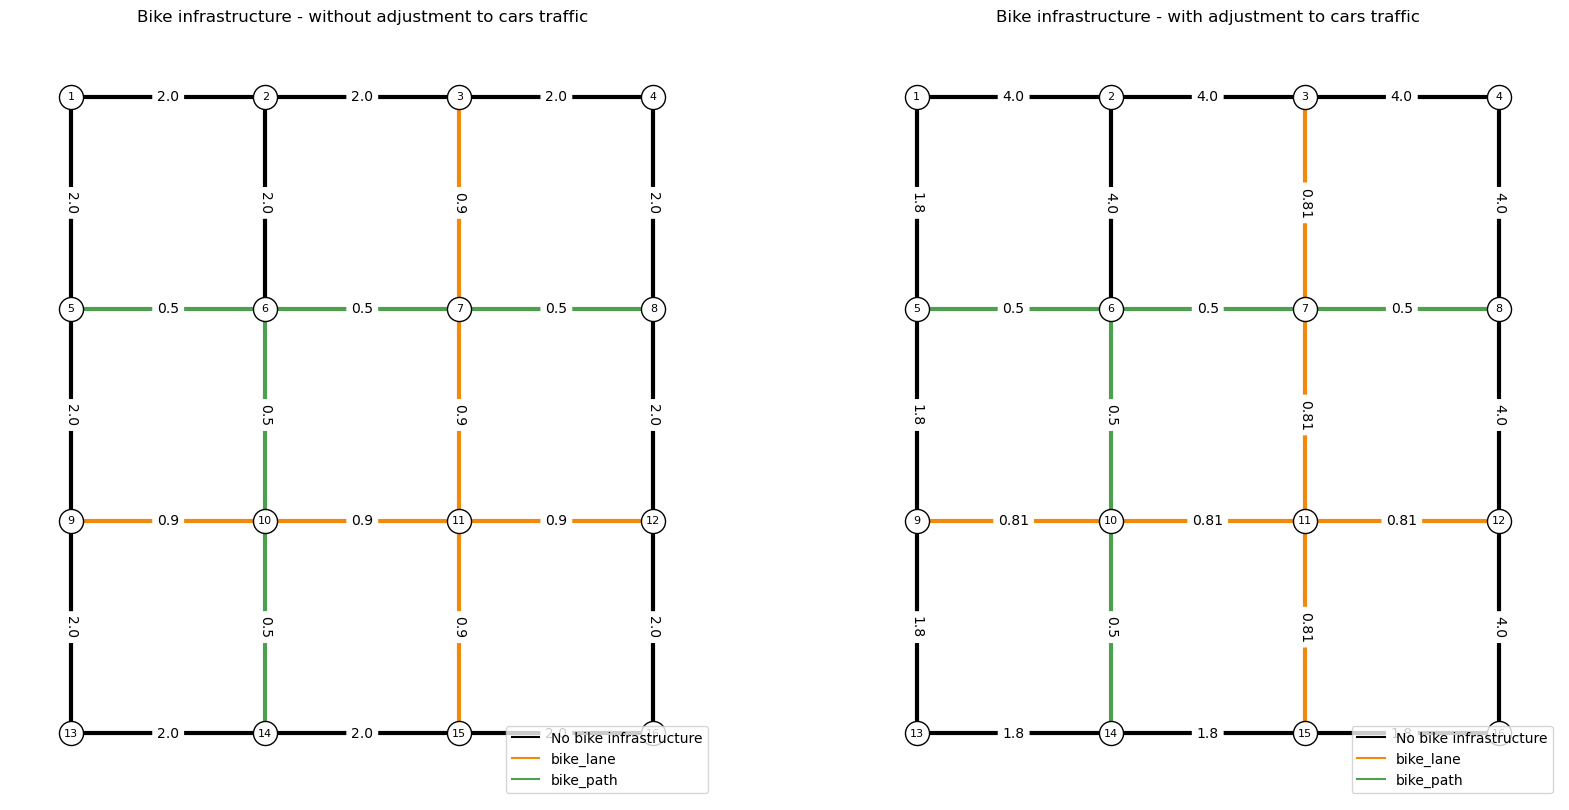

In [43]:
weight_bl = 0.9
weight_bp = 0.5
weight_no = 2
weight_no_traffic = 0.9
weight_medium_traffic = 1.1
weight_high_traffic = 2
tresh_no_traffic = 10
tresh_medium_traffic = 20

def simple_bi_3(graph):
    for u,v,d in graph.edges(data=True):
        perceived_l = d['length']
        if d['type_bike'] == 'bike_path':
            perceived_l *= weight_bp
        elif d['type_bike'] == 'bike_lane':
            if d['flow_car'] < tresh_no_traffic:
                perceived_l *= weight_bl*weight_no_traffic
            elif d['flow_car'] < tresh_medium_traffic:
                perceived_l *= weight_bl*weight_medium_traffic
            else :
                perceived_l *= weight_bl*weight_high_traffic
        else :
            if d['flow_car'] < tresh_no_traffic:
                perceived_l *= weight_no*weight_no_traffic
            elif d['flow_car'] < tresh_medium_traffic:
                perceived_l *= weight_no*weight_medium_traffic
            else :
                perceived_l *= weight_no*weight_high_traffic
        d['length_bi'] = perceived_l

G_bi_3 = G.copy()
simple_bi_3(G_bi_3)
reset_flows(G_bi_3)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_graph(G, label='length_bi', ax=axes[0])
plot_graph(G_bi_3, label='length_bi', ax=axes[1])
axes[0].set_title("Bike infrastructure - without adjustment to cars traffic")
axes[1].set_title("Bike infrastructure - with adjustment to cars traffic")

In [39]:
G_sto_bike_3 = model_eaquilibrae_stochastic(G_bi_3, od_bike, time_field='travel_time_bike', cost_field='length_bi', algorithm='bfsle', max_routes=3)

Starting stochastic assignment with bfsle algorithm...
Assignment completed successfully in 0.00 seconds.
Assignment Results:
Algorithm: bfsle
Max Routes: 3
Total Travel Time: 15.00

Total Travel Cost: 284.74



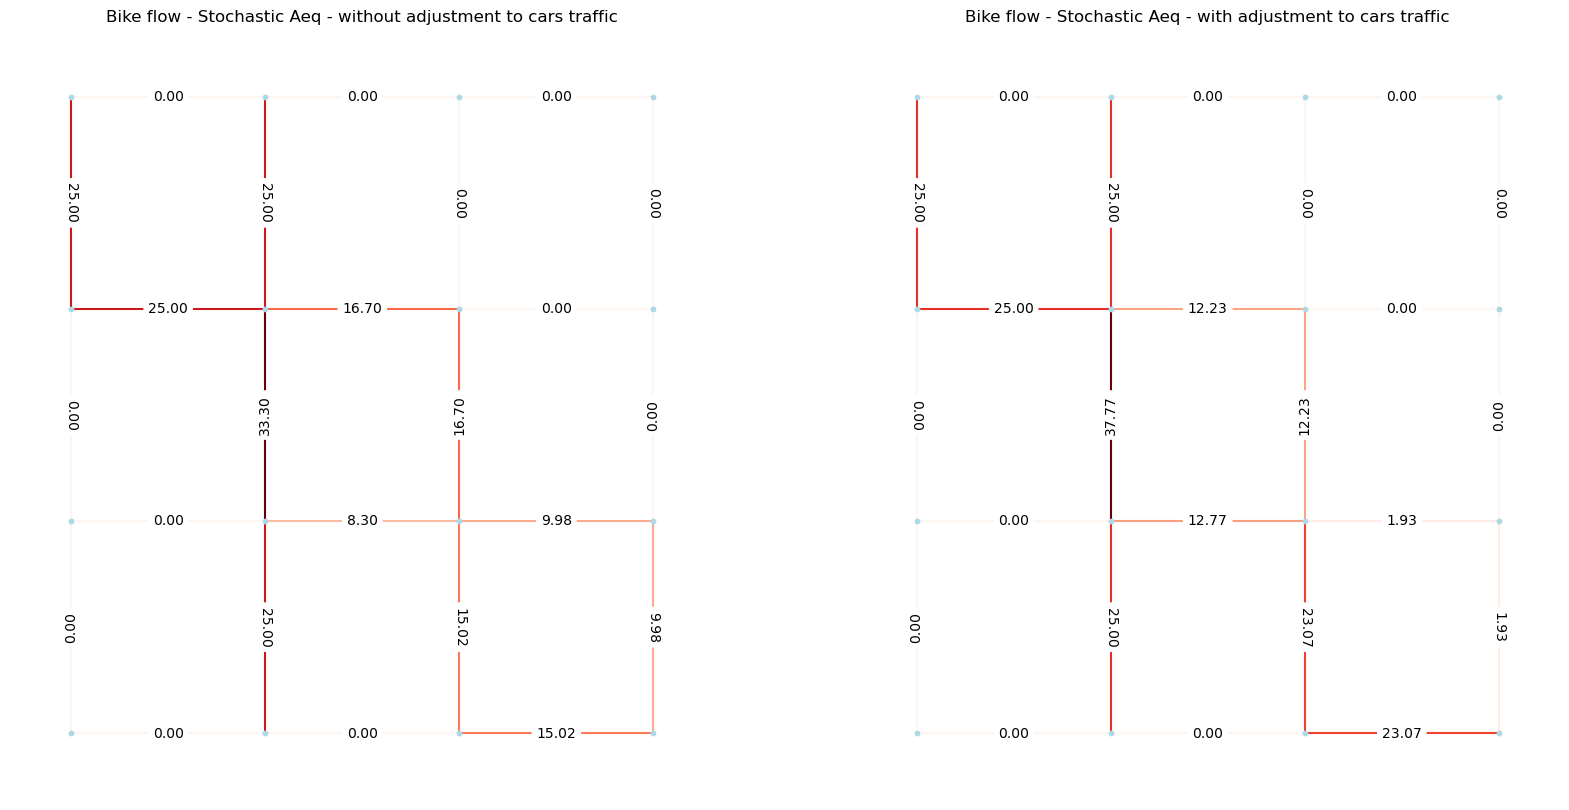

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_flow(G_sto_bike, title="Bike flow - Stochastic Aeq - without adjustment to cars traffic", pos=pos, flow_key='flow', ax=axes[0])
plot_flow(G_sto_bike_3, title="Bike flow - Stochastic Aeq - with adjustment to cars traffic", pos=pos, flow_key='flow', ax=axes[1])